# How to Classify a New SN

This tutorial demonstrates how to classify a new supernova using the method in Williamson et al. (2019).

In [12]:
import SNIDsn
import SNIDdataset as snid
import numpy as np
import SNePCA
import matplotlib.pyplot as plt
import pandas
from collections import OrderedDict

### Load preprocessed SNID datasets 

datasetX contains the SNID spectra for the phase range X +/- 5 days, where each SNe has only 1 spectrum in this phase range.  The spectrum with phase closest to X is chosen. All of the preprocessing has been applied (wavelength cut, smoothing, phase type, etc)

In [2]:
dataset0 = snid.loadPickle('../Data/DataProducts/dataset0.pickle')
dataset5 = snid.loadPickle('../Data/DataProducts/dataset5.pickle')
dataset10 = snid.loadPickle('../Data/DataProducts/dataset10.pickle')
dataset15 = snid.loadPickle('../Data/DataProducts/dataset15.pickle')

### Run PCA

In [3]:
snidPCA0 = SNePCA.SNePCA(dataset0, -5, 5)
snidPCA5 = SNePCA.SNePCA(dataset5, 0, 10)
snidPCA10 = SNePCA.SNePCA(dataset10, 5, 15)
snidPCA15 = SNePCA.SNePCA(dataset15, 10, 20)

In [4]:
snidPCA0.snidPCA()
snidPCA5.snidPCA()
snidPCA10.snidPCA()
snidPCA15.snidPCA()

Choose the arbitrary signs for the eigenspectra so that they are consistent across phases, and so that the eigenspectra features match H and He absorption features in the mean spectra.

In [5]:
snidPCA10.evecs[0] = -snidPCA10.evecs[0]

snidPCA5.evecs[1] = -snidPCA5.evecs[1]
snidPCA10.evecs[1] = -snidPCA10.evecs[1]
snidPCA15.evecs[1] = -snidPCA15.evecs[1]

snidPCA0.evecs[2] = -snidPCA0.evecs[2]
snidPCA5.evecs[2] = -snidPCA5.evecs[2]
snidPCA15.evecs[2] = -snidPCA15.evecs[2]

snidPCA0.evecs[3] = -snidPCA0.evecs[3]
snidPCA5.evecs[3] = -snidPCA5.evecs[3]
snidPCA10.evecs[3] = -snidPCA10.evecs[3]

snidPCA0.evecs[4] = -snidPCA0.evecs[4]

Calculate the PCA coefficients of the spectra in the sample.

In [6]:
snidPCA0.calcPCACoeffs()
snidPCA5.calcPCACoeffs()
snidPCA10.calcPCACoeffs()
snidPCA15.calcPCACoeffs()

In [7]:
print(snidPCA0.pcaCoeffMatrix.shape)
print(snidPCA5.pcaCoeffMatrix.shape)
print(snidPCA10.pcaCoeffMatrix.shape)
print(snidPCA15.pcaCoeffMatrix.shape)

(55, 55)
(52, 52)
(56, 56)
(54, 54)


In [8]:
# Set colors for plots
snidPCA0.Ib_color = 'steelblue'
snidPCA5.Ib_color = 'steelblue'
snidPCA10.Ib_color = 'steelblue'
snidPCA15.Ib_color = 'steelblue'
snidPCA0.IIb_color = 'limegreen'
snidPCA5.IIb_color = 'limegreen'
snidPCA10.IIb_color = 'limegreen'
snidPCA15.IIb_color = 'limegreen'
snidPCA0.IcBL_color = 'darkgrey'
snidPCA5.IcBL_color = 'darkgrey'
snidPCA10.IcBL_color = 'darkgrey'
snidPCA15.IcBL_color = 'darkgrey'


snidPCA0.IIb_ellipse_color = 'green'
snidPCA5.IIb_ellipse_color = 'green'
snidPCA10.IIb_ellipse_color = 'green'
snidPCA15.IIb_ellipse_color = 'green'
snidPCA0.IcBL_ellipse_color = 'grey'
snidPCA5.IcBL_ellipse_color = 'grey'
snidPCA10.IcBL_ellipse_color = 'grey'
snidPCA15.IcBL_ellipse_color = 'grey'


# Prepare the New SN

In order to classify a new supernova, the spectra must be preprocessed in a consistent manner with Williamson et al. (2019). This preprocessing is demonstrated in the following steps:

In [14]:
# This step assumes that you have the SNID template
# for the new supernova.

# Make a new SNIDsn object and load the SNID template.
newSN = SNIDsn.SNIDsn()
newSN.loadSNIDlnw('Tutorial_Data/18gep.lnw')

# Get the SN Name from the SNIDsn object
newSNName = newSN.header['SN']

# Make a new dataset and add the newSN
newDataset = OrderedDict()
newDataset[newSNName] = newSN

In [15]:
newDataset

OrderedDict([('18gep', <SNIDsn.SNIDsn at 0x11ba78128>)])

In [16]:
# Replace the 0.0 gap placeholder with NaN
snid.snidsetNAN(newDataset)

In [17]:
# Interpolate gaps in the spectra
snid.interpGaps(newDataset, minwvl=4000, maxwvl=7000, maxgapsize=20)

In [18]:
# Cut the wavelength range to 4000 to 7000 Angstroms
snid.datasetWavelengthRange(newDataset, minwvl=4000, maxwvl=7000)

In [23]:
# Show the phases of your new SN
print(newSN.phases)

# All column names are preceded by 'Ph'
print(newSN.data.dtype)

[-3.7  4.3]
[('Ph-3.7', '<f4'), ('Ph4.3', '<f4')]


In [24]:
# Smooth the spectra
newSN.smoothSpectrum(phase='Ph-3.7', velcut=3000)
newSN.smoothSpectrum(phase='Ph4.3', velcut=3000)

In [27]:
# Choose the phase range to classify in from Williamson et al. (2019)
# and keep only the phase closest to the center of the range.
snid.filterPhases(newDataset, [(-5,5)], True)

print(newSN.phases)

[-3.7]


### Calculate the PCA Coefficients of the New SN

In [38]:
# Calculating the PCA coefficients is easy. You just need
# the dot product of the new spectrum with the eigenspectra
# from Williamson et al. (2019)
pca_coef_early = np.dot(snidPCA0.evecs, newSN.data['Ph-3.7'])

In [39]:
# Williamson et al. (2019) focuses on the first 5 eigenspectra
pca_coef[0:5]

array([-0.06635382, -0.33910029, -0.06883574,  0.17584635,  0.16109871])

# Prepare Williamson et al. (2019) Fig 5

You will want to plot the new SN on Fig 5 from Williamson et al. (2019)

['sn1998dt' 'sn1999dn' 'sn1999ex' 'sn2004gq' 'sn2005bf' 'sn2005hg'
 'sn2007ag' 'sn2007C' 'sn2007kj' 'sn2007Y' 'sn2008D' 'sn2009jf' 'sn2012P'
 'sn2013df' 'sn2016gkg' '11hs' 'sn1993J' 'sn1996cb' 'sn1998fa' 'sn2000H'
 'sn2004ff' 'sn2006el' 'sn2008bo' 'sn2009mg' 'sn2011dh' 'sn2011ei'
 'sn2011fu' 'LSQ14efd' '13ge' '15dtg' 'sn1994I' 'sn2004aw' 'sn2004fe'
 'sn2005az' 'sn2005kl' 'sn2005mf' 'sn2007gr' 'sn2011bm' 'sn2013dk' '16coi'
 'sn1997ef' 'sn1998bw' 'sn2002ap' 'sn2003jd' 'sn2003lw' 'sn2006aj'
 'sn2007ru' 'sn2009bb' 'sn2010bh' 'sn2012ap' 'sn2012bz' 'sn2013dx']
IIb
IIb - x:  [4.60383504 2.333701   1.41295091 3.90509078 2.32418179 2.07415746
 0.86025383 3.44926379 3.29070672 1.83025395 3.00431748 3.3039581
 4.8256219  2.62624378 2.09056375]
IIb - y:  [ 0.92711382  0.47005991 -2.14223534  0.32180898  0.91415531 -0.25466803
  0.86632402  0.24824726  0.4516151   0.08394257  0.99484302  1.03945249
  1.2354316   0.31185824  0.68114427]
mean =  (2.795673352441344, 0.4099395467202116)
Ib
(12,)
(14,)


/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:725: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:727: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:729: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:731: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



rad namemask:  [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
IIb radx, rady (1.562748962256792, 1.057627139869169)
Ib radx, rady (0.8463946339800552, 0.8010454291257888)
Ic radx, rady (0.9033481315441833, 0.6142207037608178)
IcBL radx, rady (0.4773352542249077, 0.24552551279487903)
rad mask:  0.8463946339800552 0.8010454291257888
rad all:  1.1399581964181205 0.7888286261011331
names all:  ['sn1998dt' 'sn1999dn' 'sn1999ex' 'sn2005bf' 'sn2006ep' 'sn2007ag'
 'sn2007C' 'sn2007kj' 'sn2007Y' 'sn2008D' 'sn2009er' 'sn2009iz' 'sn2009jf']
IIb 2std outliers:  ['sn2016gkg' '10as' 'sn2011ei']
Ib 2std outliers:  ['sn1998dt' 'sn2007kj' 'sn2007Y' 'sn2009er']
Ic 2std outliers:  ['sn1990B']
IcBL 2std outliers:  ['16coi' 'sn2002ap' 'sn20

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:725: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:727: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:729: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:731: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



rad namemask:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
IIb radx, rady (1.0801274644566687, 1.0714297454666681)
Ib radx, rady (1.0358562355572722, 0.7058388667193474)
Ic radx, rady (0.9509289631066491, 0.4437633645532546)
IcBL radx, rady (0.5354122186766904, 0.18038050871790856)
rad mask:  1.0358562355572722 0.7058388667193474
rad all:  1.1691995685159062 0.6926571760465225
names all:  ['sn1983N' 'sn1990I' 'sn1990U' 'sn1998dt' 'sn1999dn' 'sn1999ex' 'sn2004dk'
 'sn2004gv' 'sn2005bf' 'sn2005hg' 'sn2006ep' 'sn2007ag' 'sn2007C'
 'sn2007uy' 'sn2007Y' 'sn2008D' 'sn2009iz' 'sn2009jf']
IIb 2std outliers:  ['sn2011ei']
Ib 2std outliers:  ['sn1990I' 'sn1990U' 'sn1999ex' 'sn2007uy']
Ic 2std outliers: 

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:725: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:727: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:729: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:731: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/miniconda3/envs/sesn/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/marcwilliamson/miniconda3/envs/sesn/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of

rad namemask:  [ True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
IIb radx, rady (1.0808228031157667, 0.8876004494084153)
Ib radx, rady (1.2397321600446207, 1.0487650787453475)
Ic radx, rady (0.7101147694918134, 0.5645329496862641)
IcBL radx, rady (0.42317377217304963, 0.5145324601987891)
rad mask:  1.2397321600446207 1.0487650787453475
rad all:  1.465093883949425 0.9890533451169512
names all:  ['sn1983N' 'sn1990I' 'sn1990U' 'sn1998dt' 'sn1999dn' 'sn2004dk' 'sn2004gq'
 'sn2004gv' 'sn2005hg' 'sn2006ep' 'sn2007C' 'sn2007uy' 'sn2007Y' 'sn2008D'
 'sn2009er' 'sn2009iz' 'sn2009jf']
IIb 2std outliers:  ['sn2011ei']
Ib 2std outliers:  ['sn1990I' 'sn2004gq' 'sn2007uy' 'sn2007Y' 'sn2009er']
Ic 2std outliers:  ['sn1994I']


/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:725: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:727: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:729: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/Users/marcwilliamson/src/dev/SESNspectraPCA/code/SNePCA.py:731: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



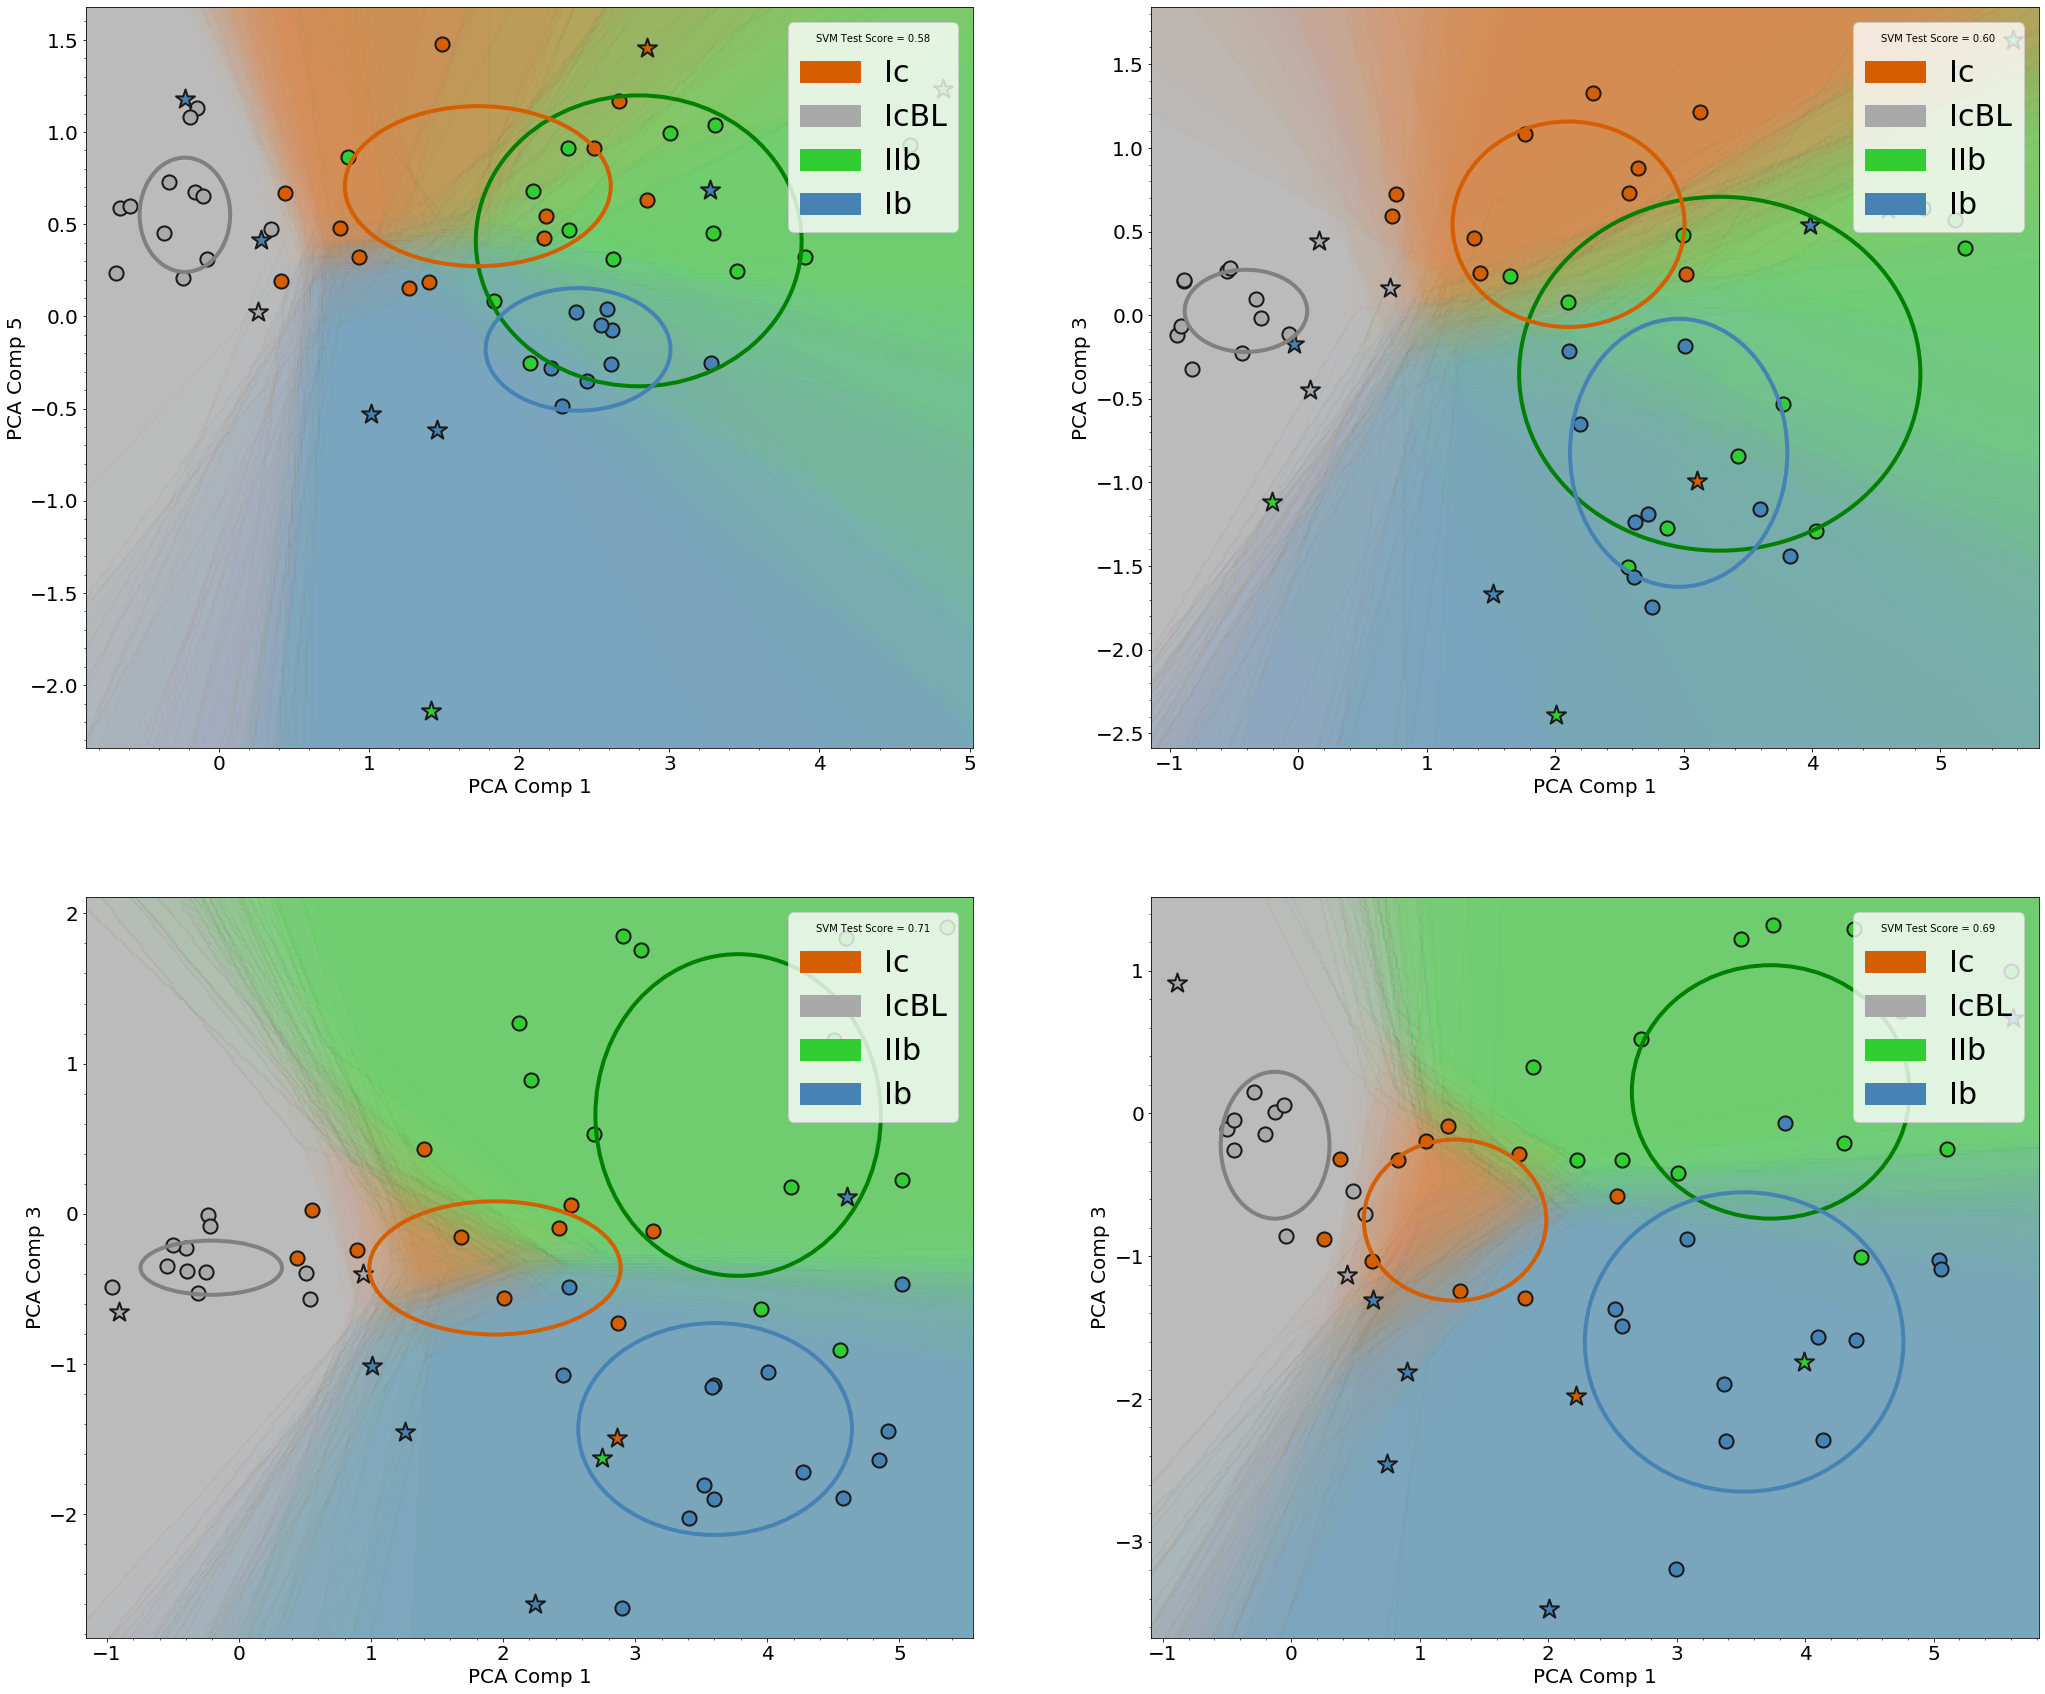

In [33]:
f_all, axs = plt.subplots(2,2,figsize=(35,30),gridspec_kw={'wspace':.2,'hspace':.2})
#Exclude Ib-pec and Ic-pec SNe
exclude = ['sn2007uy', 'sn2009er', 'sn2005ek']
svmsc=[]
f_all,svmsc,av0,std0=snidPCA0.pcaPlot(1,5,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,purity=True,
                                     excludeSNe=exclude, std_rad=1.0, svm=True, count=3, fig=f_all,
                                     ax=f_all.axes[0],ncv=50, markOutliers=True)
print(av0, std0)
svmsc=[]
f_all,svmsc, av5, std5=snidPCA5.pcaPlot(1,3,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,purity=True, 
                                       excludeSNe=exclude,std_rad=1.0, svm=True, count=3, 
                                       fig=f_all, ax=f_all.axes[1], ncv=50, markOutliers=True)
print(av5, std5)
svmsc=[]
f_all,svmsc, av10, std10=snidPCA10.pcaPlot(1,3,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,
                                          purity=True,excludeSNe=exclude, std_rad=1.0, svm=True,
                                          count=3, fig=f_all, ax=f_all.axes[2],ncv=50, markOutliers=True)
print(av10, std10)
svmsc=[]
f_all,svmsc, av15, std15=snidPCA15.pcaPlot(1,3,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,
                                          purity=True, excludeSNe=exclude,std_rad=1.0,
                                          svm=True, count=3, fig=f_all, ax=f_all.axes[3],ncv=50, markOutliers=True)
print(av15, std15)

In [34]:
for i,ax in enumerate(f_all.axes):
    l = ax.get_legend()
    t = l.get_title()
    t.set_fontsize(30)
    ax.tick_params(axis='both',which='major', length=20,direction='inout',labelsize=35)
    ax.tick_params(axis='both',which='minor', length=10,direction='inout')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    if i==0:
        l = ax.get_legend()
        t = l.get_title()
        l.set_title('')
        ymax = ymax + 0.5
        ax.set_ylim((ymin,ymax+0.5))
        ax.text(xmin + .1,ymax - .3,'$t_{V_{max}} = 0 \pm 5$ days\nSVM Test Score = %.2f$\pm$%.2f'%(av0,std0),fontsize=45)
        ax.set_ylabel('PC5', fontsize=50)
        ax.set_xlabel('PC1', fontsize=50)
    elif i==1:
        ymax = ymax + 0.5
        ax.set_ylim((ymin,ymax+0.5))
        ax.text(xmin + .1,ymax - .2,'$t_{V_{max}} = 5 \pm 5$ days\nSVM Test Score = %.2f$\pm$%.2f'%(av5,std5),fontsize=45)
        ax.set_ylabel('PC3', fontsize=50)
        ax.set_xlabel('PC1', fontsize=50)
        ax.get_legend().remove()
    elif i==2:
        ymax = ymax + 0.5
        ax.set_ylim((ymin,ymax+0.5))
        ax.text(xmin + .1,ymax - .4,'$t_{V_{max}} = 10 \pm 5$ days\nSVM Test Score = %.2f$\pm$%.2f'%(av10,std10),fontsize=45)
        ax.set_ylabel('PC3', fontsize=50)
        ax.set_xlabel('PC1', fontsize=50)
        ax.get_legend().remove()
    else:
        ymax = ymax + 0.5
        ax.set_ylim((ymin,ymax+0.5))
        ax.text(xmin + .1,ymax - .4,'$t_{V_{max}} = 15 \pm 5$ days\nSVM Test Score = %.2f$\pm$%.2f'%(av15,std15),fontsize=45)
        ax.set_ylabel('PC3', fontsize=50)
        ax.set_xlabel('PC1', fontsize=50)
        ax.get_legend().remove()

In [35]:
#IIb 2std outliers:  ['sn2016gkg' 'sn2011dh']
#Ib 2std outliers:  ['sn2004gq' 'sn2007uy' 'sn1998dt' 'sn2009er' 'sn2007kj']
#Ic 2std outliers:  ['sn2005az']
#IcBL 2std outliers:  ['sn2010bh']
ax = f_all.axes[0]

ax.text(-.22,1.25,'07uy',fontdict={'color':'k','fontsize':35})
ax.text(.352,.302,'09er',fontdict={'color':'k','fontsize':35})
ax.text(.6,-.82,'04gq',fontdict={'color':'k','fontsize':35})
ax.text(1.45,-0.85,'98dt',fontdict={'color':'k','fontsize':35})
ax.text(3.3,.69,'07kj',fontdict={'color':'k','fontsize':35})

ax.text(1.413,-2.14,'16gkg',fontdict={'color':'k','fontsize':35})
ax.text(4.15,1.08,'11dh',fontdict={'color':'k','fontsize':35})

ax.text(0.25,-0.25,'10bh',fontdict={'color':'k','fontsize':35})

ax.text(2.9,1.48,'05az',fontdict={'color':'k','fontsize':35})



#IIb 2std outliers:  ['sn2011ei' '10as']
#Ib 2std outliers:  ['sn1998dt' 'sn2009er' 'sn2007Y']
#Ic 2std outliers:  ['sn1990B']
#IcBL 2std outliers:  ['sn2002ap' '16coi']
ax = f_all.axes[1]

ax.text(2.11,-2.5,'11ei',fontdict={'color':'k','fontsize':35})
ax.text(5.1,1.8,'10as',fontdict={'color':'k','fontsize':35})

ax.text(0.08,-.31,'09er',fontdict={'color':'k','fontsize':35})
ax.text(4.56,.76,'07Y',fontdict={'color':'k','fontsize':35})
ax.text(1.58,-1.72,'98dt',fontdict={'color':'k','fontsize':35})

ax.text(2.7,-0.8,'90B',fontdict={'color':'k','fontsize':35})

ax.text(.75,.0,'02ap',fontdict={'color':'k','fontsize':35})
ax.text(.08,-.6,'16coi',fontdict={'color':'k','fontsize':35})

ax.text(-0.16,-1.12,'16gkg',fontdict={'color':'k','fontsize':35})

ax.text(-0.28,.55,'07bg',fontdict={'color':'k','fontsize':35})

ax.text(3.79,.66,'07kj',fontdict={'color':'k','fontsize':35})







#IIb 2std outliers:  ['sn2011ei']
#Ib 2std outliers:  ['sn2007uy' 'sn1990U' 'sn1990I']
#Ic 2std outliers:  ['sn1994I']
#IcBL 2std outliers:  ['sn2002ap' 'sn2007bg']
ax = f_all.axes[2]

ax.text(1.15,-.97,'07uy',fontdict={'color':'k','fontsize':35})
ax.text(1.39,-1.40,'90I',fontdict={'color':'k','fontsize':35})
ax.text(4.69,.28, '90U',fontdict={'color':'k','fontsize':35})


ax.text(2.56,-2.0,'11ei',fontdict={'color':'k','fontsize':35})

ax.text(2.99,-1.40,'94I',fontdict={'color':'k','fontsize':35})

ax.text(1.03,-.33,'02ap',fontdict={'color':'k','fontsize':35})
ax.text(-1.02,-.95,'07ru',fontdict={'color':'k','fontsize':35})

ax.text(1.72,-2.40,'99ex',fontdict={'color':'k','fontsize':35})





#IIb 2std outliers:  ['sn2011ei']
#Ib 2std outliers:  ['sn2007uy' 'sn1990I' 'sn2009er' 'sn2004gq' 'sn2007Y']
#Ic 2std outliers:  ['sn1994I']
#IcBL 2std outliers:  ['sn2010ay' '16coi']
ax = f_all.axes[3]

ax.text(.66,-1.18,'09er',fontdict={'color':'k','fontsize':35})
ax.text(.95,-1.79,'07uy',fontdict={'color':'k','fontsize':35})
ax.text(.85,-2.38,'90I',fontdict={'color':'k','fontsize':35})
ax.text(5.06,0.58,'07Y',fontdict={'color':'k','fontsize':35})
ax.text(2.08,-3.43,'04gq',fontdict={'color':'k','fontsize':35})

ax.text(3.72,-2.09,'11ei',fontdict={'color':'k','fontsize':35})

ax.text(2.34,-1.85,'94I',fontdict={'color':'k','fontsize':35})

ax.text(-.9,.88,'10ay',fontdict={'color':'k','fontsize':35})
ax.text(-0.4,-1.3,'16coi',fontdict={'color':'k','fontsize':35})

#ax.text(2.0, 1.0, 'Test', color='green',fontdict={'color':'k','fontsize':35}, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round',alpha=.5))

Text(-0.4, -1.3, '16coi')

# Plot the New SN in the Appropriate Panel

In [44]:
# Since the new SN has phase = -3.7 it should 
# be plotted in the top left panel.
ax = f_all.axes[0]

ax.scatter([pca_coef[0]], [pca_coef[4]], color='purple', marker='*', s=2000)

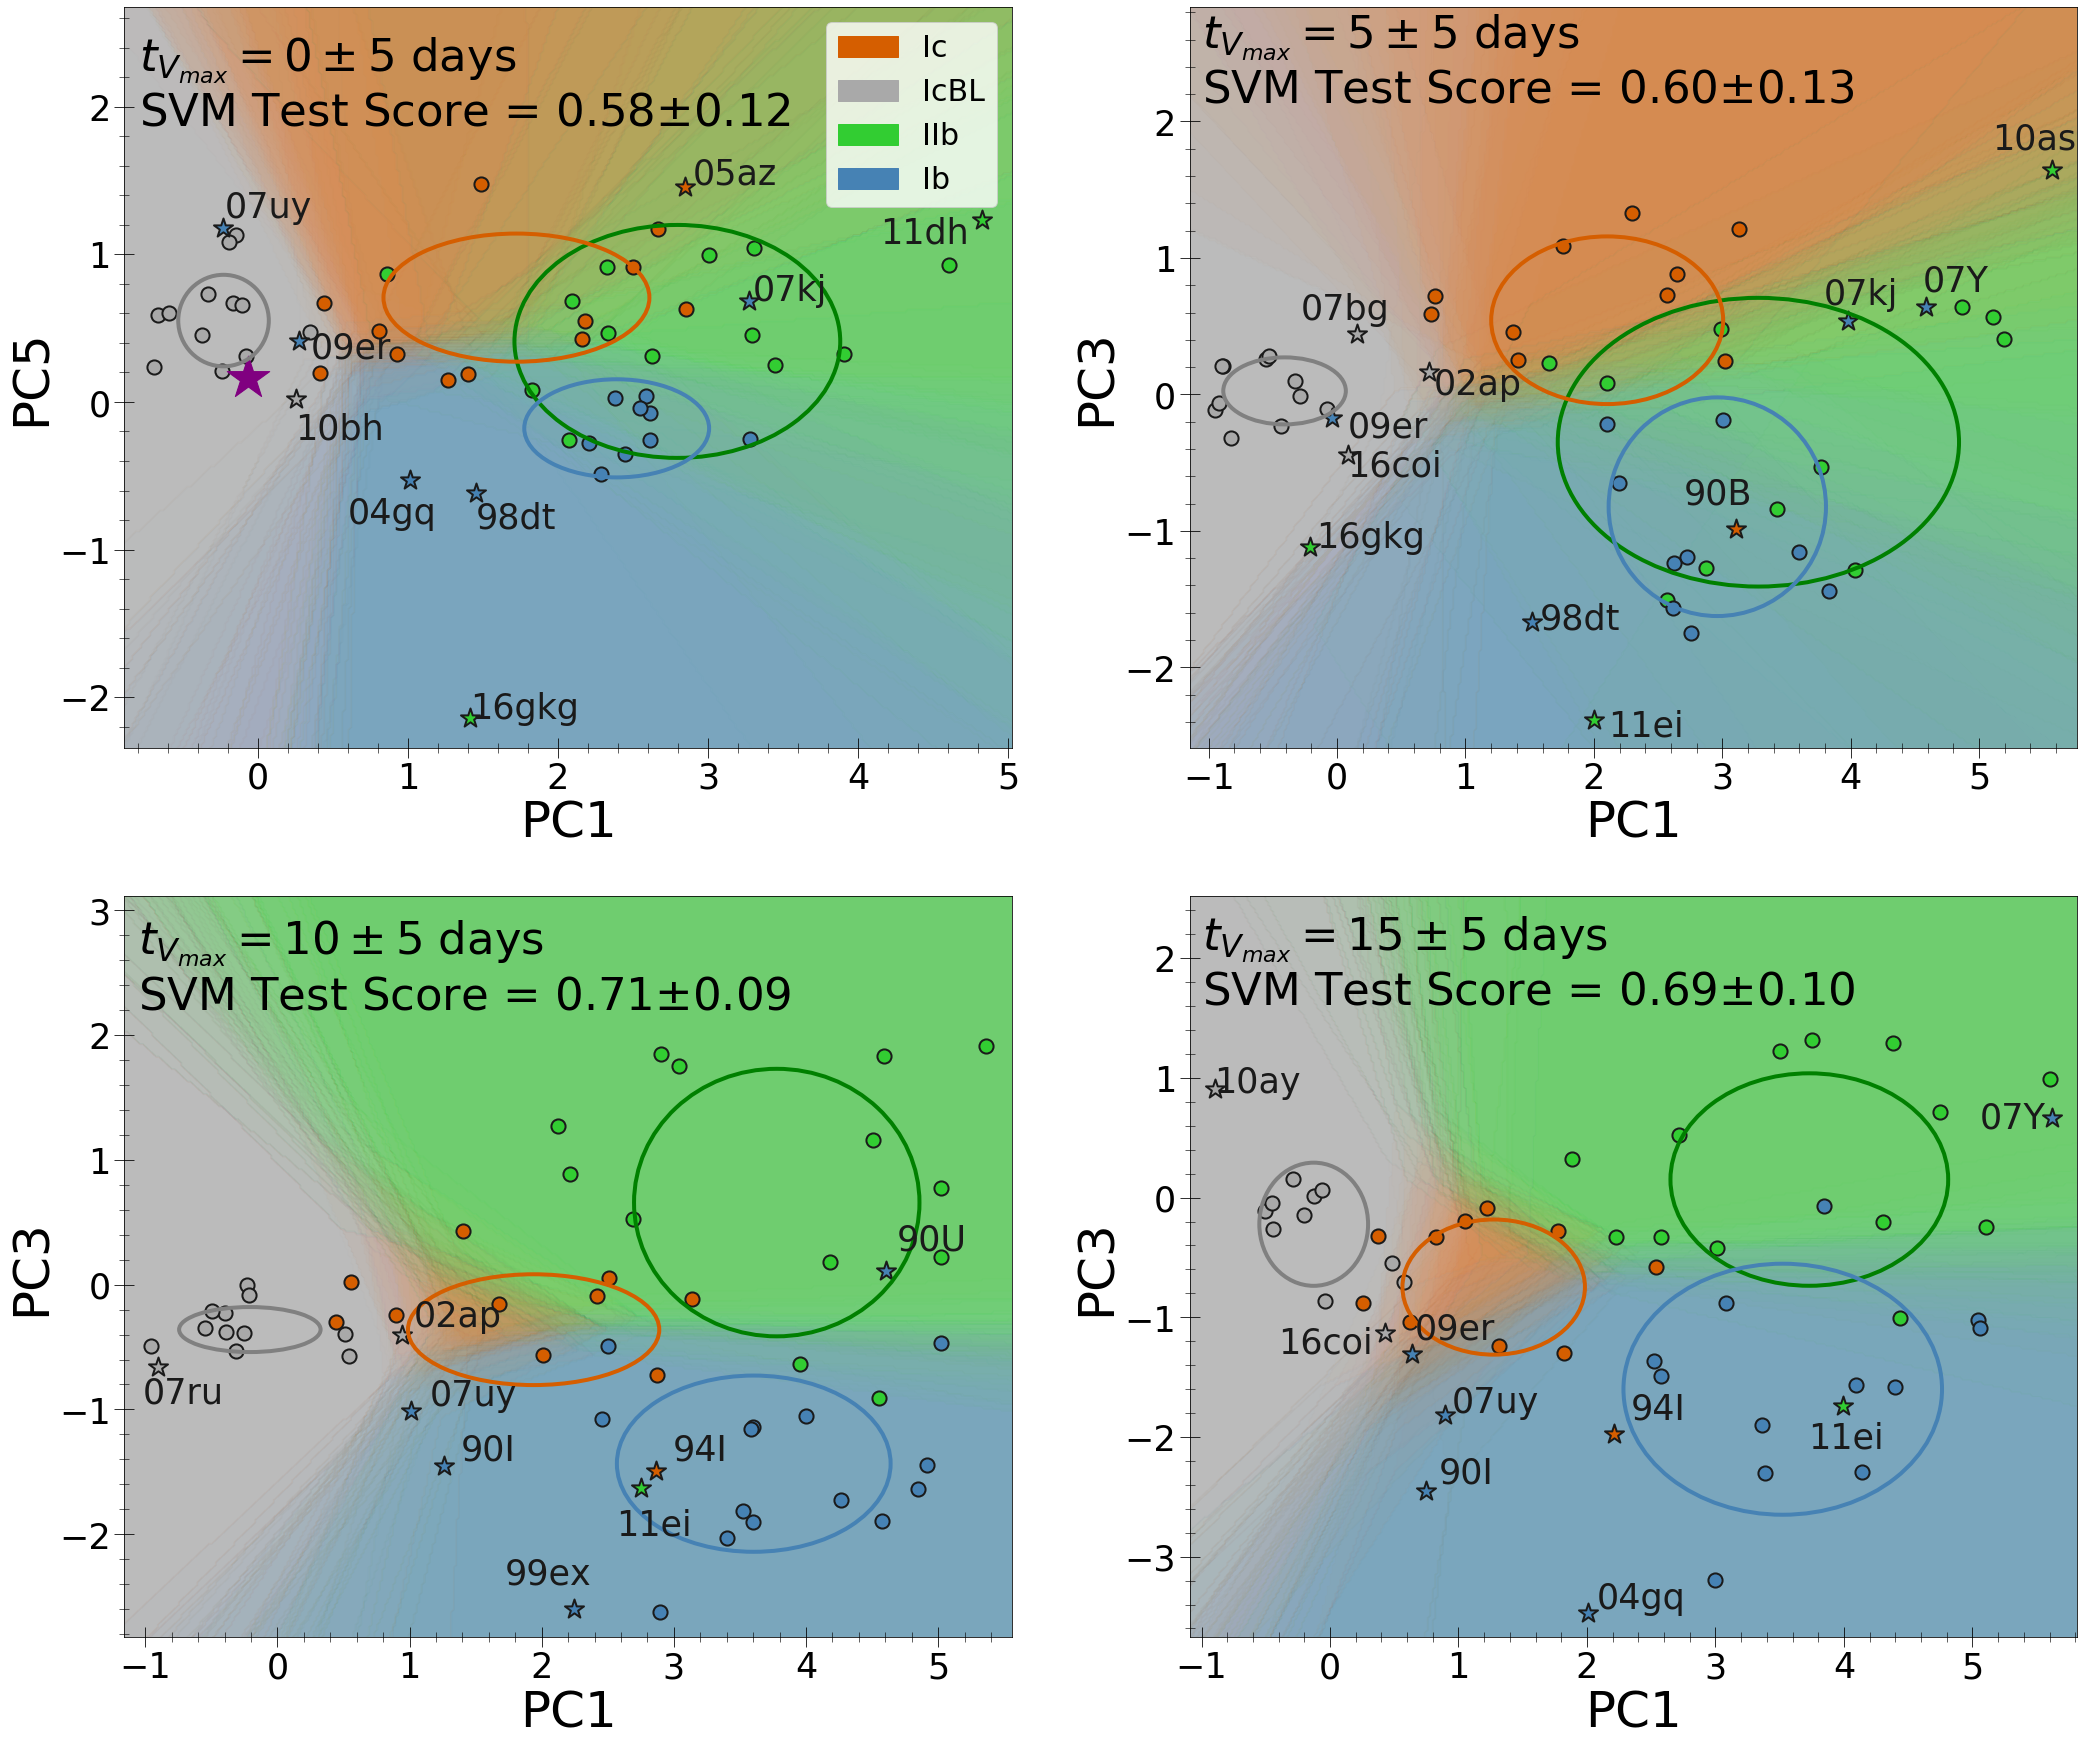

In [45]:
f_all

# Interpret

The new SN appears to be a IcBL (which SN2018gep is)